In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab09.ipynb")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Lab 9: Time Series
### Using Zillow to Predict CPI
In this notebook, we're going to try to use data from Zillow (specifically, their ZORI index) to see if we can use it to predict the US consumer price index.

---
## Part 1: Introduction and Data Processing

### Dataset 1: ZORI

We've downloaded the ZORI index for you from [Zillow Research Data](https://www.zillow.com/research/data/). Run the following cell to display information about the ZORI index. What can you tell from the data?

In [3]:
zori = pd.read_csv("data/zori1.csv")
zori

,RegionID,SizeRank,RegionName,RegionType,StateName,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,102001,0,United States,country,NaN,1370.301806,1381.971304,1392.389090,1403.203509,1408.901384,...,1928.945108,1937.304351,1955.272060,1971.256988,1997.731260,2019.752839,2044.662959,2065.275748,2078.546078,2084.084210
1,394913,1,"New York, NY",msa,NY,2506.196326,2533.311441,2552.989317,2570.501028,2573.663435,...,2957.725252,2984.899451,3032.151836,3082.959790,3142.381057,3201.035347,3258.611614,3308.938574,3327.647323,3321.271717
2,753899,2,"Los Angeles, CA",msa,CA,1977.874325,1990.644815,2004.443160,2016.922137,2031.255505,...,2808.206899,2825.516662,2850.339483,2881.506596,2919.113666,2953.089197,2978.850604,2999.777869,3013.211794,3019.026316
3,394463,3,"Chicago, IL",msa,IL,1478.149264,1490.961012,1502.702134,1528.952557,1535.997197,...,1795.629571,1808.471849,1823.778075,1843.010280,1865.307537,1890.513951,1911.437953,1930.811578,1939.370439,1941.933786
4,394514,4,"Dallas, TX",msa,TX,1180.713035,1191.112125,1202.397600,1209.409429,1216.117716,...,1724.699775,1736.260930,1747.886285,1758.449166,1780.575633,1807.486899,1842.009269,1866.378789,1876.715983,1875.844643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,394322,861,"Altus, OK",msa,OK,404.816596,NaN,417.170690,NaN,NaN,...,NaN,NaN,NaN,735.821384,732.921061,771.810020,755.232683,810.606473,750.000000,821.649685
575,394687,869,"Hood River, OR",msa,OR,NaN,NaN,NaN,708.148593,NaN,...,NaN,2039.794902,NaN,2061.477514,2053.911628,2293.863629,2446.688466,2573.551207,2575.000000,2617.167354
576,394718,892,"Jamestown, ND",msa,ND,NaN,NaN,NaN,NaN,NaN,...,643.033893,632.188630,NaN,668.388884,715.417127,687.157390,702.818101,729.449277,771.000000,795.646586
577,394330,906,"Andrews, TX",msa,TX,NaN,NaN,480.844237,470.002683,NaN,...,NaN,901.423609,NaN,NaN,NaN,NaN,NaN,NaN,962.000000,1019.826674


<!-- BEGIN QUESTION -->

**Question 1.1:** What information is stored in the ZORI data? What does each row represent?

Each row in the Zillow Observed Rent Index (ZORI) dataset represents a region in the US (or the US as a whole). Every row contains data of a smoothed measure of the typical observed market rate rent across the given region (or the US) for every month from March 2015 to September 2022.

<!-- END QUESTION -->

Below, we select rows within the ZORI dataframe that have the timeseries corresponding to the ZORI index for the entire country.

In [4]:
zUS = zori.iloc[[0], :-1]
zUS

,RegionID,SizeRank,RegionName,RegionType,StateName,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,...,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31
0,102001,0,United States,country,NaN,1370.301806,1381.971304,1392.38909,1403.203509,1408.901384,...,1915.496408,1928.945108,1937.304351,1955.27206,1971.256988,1997.73126,2019.752839,2044.662959,2065.275748,2078.546078


We notice that the dates in the timeseries actually start from the 6th entry in the index. If we wanted to create a DataFrame, we would need to find a way to extract this information, in addition to the data stored in the ZORI column.

**Question 1.2:** Transpose the dataframe `zUS`, select the relevant columns and convert them into rows (similar to the picture below). Rename the column names to `DATE` and `ZORI`. Ensure the `DATE` column has an appropriate data type. The resulting dataframe `zillow` should look like the following:

| DATE | ZORI |
| ----------- | ----------- |
| 2015-03-31 | 1370.301806 |
| 2015-04-30 | 1381.971304 |
|  | ... (rows omitted) |

In [5]:
zillow = zUS.iloc[:, 5:].T.reset_index()
zillow.columns = ['DATE','ZORI']
zillow['DATE'] = pd.to_datetime(zillow['DATE'])
zillow

,DATE,ZORI
0,2015-03-31,1370.301806
1,2015-04-30,1381.971304
2,2015-05-31,1392.389090
3,2015-06-30,1403.203509
4,2015-07-31,1408.901384
...,...,...
85,2022-04-30,1997.731260
86,2022-05-31,2019.752839
87,2022-06-30,2044.662959
88,2022-07-31,2065.275748


In [6]:
grader.check("q1_2")

q1_2 results: All test cases passed!

We might wonder what this looks like. Let's graph this time series.

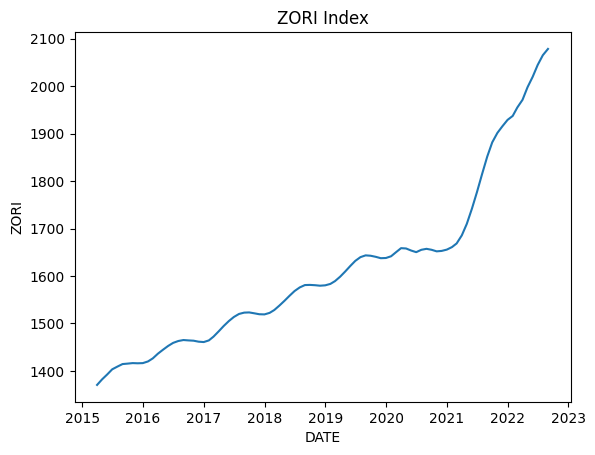

In [7]:
sns.lineplot(data=zillow, x="DATE", y="ZORI")
plt.title("ZORI Index");

Do you notice anything interesting about this graph? 

A drastic increase around 2021.

We'll focus on the part where the slope becomes noticably steeper. Around what time did this happen? What are some possible explanations?

### Dataset 2: US CPI

We'll now turn our attention to the US CPI.

We've downloaded historical **US CPI data for rent of primary residence** from the [FRED website](https://fred.stlouisfed.org/series/CUUR0000SEHA). Since our ZORI data starts on 03/31/2015, we've adjusted the sliders on the FRED website to only extract starting from 03/31/2015. We've also renamed the columns to be more readable.

In [8]:
usCPI = pd.read_csv("data/usCPI.csv")
usCPI = usCPI.rename(columns={"CUUR0000SEHA": "CPI"})
usCPI = usCPI.iloc[1:, :]
usCPI['DATE'] = pd.to_datetime(usCPI['DATE'], format='%Y-%m-%d')
usCPI

,DATE,CPI
1,2015-04-01,283.598
2,2015-05-01,284.245
3,2015-06-01,285.031
4,2015-07-01,286.090
5,2015-08-01,287.068
...,...,...
86,2022-05-01,365.116
87,2022-06-01,367.927
88,2022-07-01,370.448
89,2022-08-01,373.283


We can try plotting this to see what it looks like.

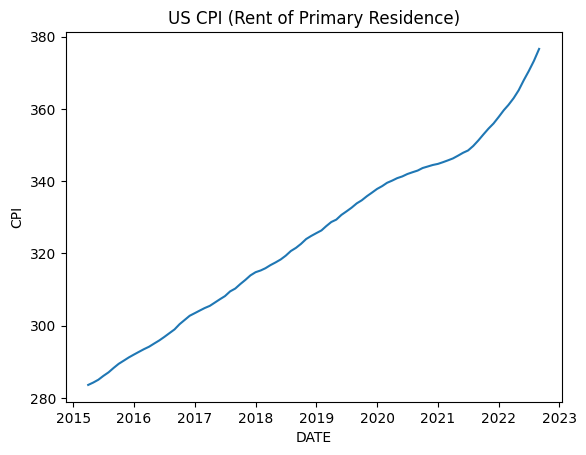

In [9]:
sns.lineplot(data=usCPI, x="DATE", y="CPI")
plt.title("US CPI (Rent of Primary Residence)");

### Data Preprocessing

In [10]:
# set `DATE` as the index
zillow = zillow.set_index('DATE')
usCPI = usCPI.set_index('DATE')

**Question 1.3:** Let's split the `usCPI` dataframe into a training set and testing set. Put all data before Jan. 1st, 2022 into the training set, and all data on or after Jan. 1st, 2022 into the testing set. 

Note: This is not how normally we do the train-test split. In a normal setup, we would assign a random portion of the data to training set and the rest to testing set. But in this analysis, we care about how well can we predict the future values using current values, so we'll create a train-test split based on a date. 

Hint: You can use `pd.to_datetime("2022-01-01", format='%Y-%m-%d')` to generate a timestamp for comparison. 

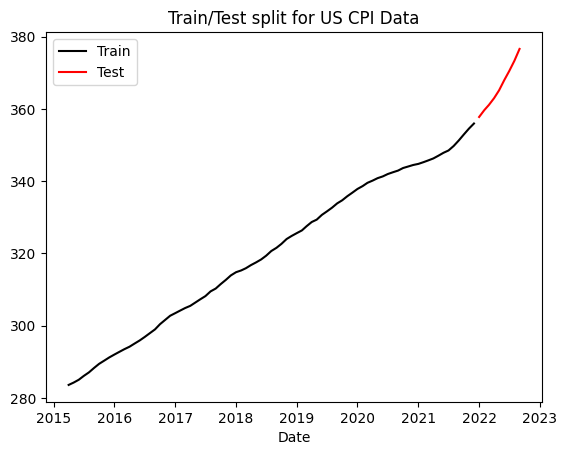

In [11]:
train = usCPI.loc['2015-04-01':'2021-12-01']
test = usCPI.loc['2022-01-01':]
plt.plot(train['CPI'], color = "black", label='Train')
plt.plot(test['CPI'], color = "red", label='Test')
plt.ylabel('')
plt.xlabel('Date')
plt.title("Train/Test split for US CPI Data")
plt.legend();

In [12]:
grader.check("q1_3")

q1_3 results: All test cases passed!

In [13]:
# generate train test CPI series
y_train = train['CPI']
y_test = test['CPI']

---
## Part 2: Time Series Modeling

In [14]:
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


import warnings
warnings.filterwarnings("ignore")

### Review
Let $X_t$ be a sequence of random variables that describes a time series model. 

* **Random walk**:   
A random walk is a time series model where the current observation is equal to the previous observation with a random step up or down. The model is widely used for non-stationary data, particularly financial and economic data.

$$X_t = X_{t-1} + \varepsilon_t$$ 

* **Random walk with drift**:   
If the random walk has a non-zero dift and acts like a trend, we will add an additional drift term ($\alpha$) to the process. 

$$X_t = X_{t-1} + \alpha + \varepsilon_t$$ 

* **Autoregressive (AR)**: AR(p) refers to the autoregressive model of order p.  
The autoregressive model uses observations from previous time steps as input to a regression equations to predict the value at the next step. The AR model takes in one argument, p, which determines how many previous time steps will be inputted.

$$X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \cdots + \phi_p X_{t-p} + \varepsilon_t$$ 

* **Moving-average (MA)**: MA(q) refers to the moving average model of order q. 
The moving average model is a time series model that accounts for very short-run autocorrelation. 

$$X_t = \mu + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \cdots + \theta_q \varepsilon_{t-q}$$ 

### Autoregressive Moving Average (ARMA)
The notation ARMA(p, q) refers to the model with p autoregressive terms and q moving-average terms. This model contains the AR(p) and MA(q) models. 

$$X_t = c + \underbrace{\phi_1 X_{t-1} + \phi_2 X_{t-2} + \cdots + \phi_p X_{t-p}}_{AR(p)} + \underbrace{\theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \cdots + \theta_q \varepsilon_{t-q}}_{MA(q)} + \varepsilon_t $$ 

Here's a summary table for the relationship between ARIMA model and the models discussed. 

| Model | ARMA(p, q) |
| ----------- | ----------- |
| White noise | ARMA(0,0) |
| Autoregression (AR(p)) | ARMA(p,0) |
| Moving average (MA(q)) | ARMA(0,q) |

Now let's try fit our data using ARMA(1, 1), which is saying we want to fit our CPI data to the following process:

$$CPI_t = c + \underbrace{\phi_1 CPI_{t-1}}_{AR(1)} + \underbrace{\theta_1 \varepsilon_{t-1}}_{MA(1)} + \varepsilon_t $$ 

In [15]:
ARMAmodel = ARIMA(y_train, order = (1, 0, 1)) # ARMA(1, 1). See ARIMA (next section) for why there's a zero
ARMAmodel = ARMAmodel.fit() 

In [16]:
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) # 95% CI
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_df

,lower CPI,upper CPI,Predictions
DATE,,,
2022-01-01,355.406492,357.700091,356.553291
2022-02-01,354.173176,358.902513,356.537845
2022-03-01,353.381618,359.663191,356.522405
2022-04-01,352.747476,360.266467,356.506971
2022-05-01,352.202086,360.781003,356.491544
2022-06-01,351.715715,361.236532,356.476124
2022-07-01,351.272269,361.649150,356.460710
2022-08-01,350.861869,362.028736,356.445303
2022-09-01,350.477932,362.381872,356.429902


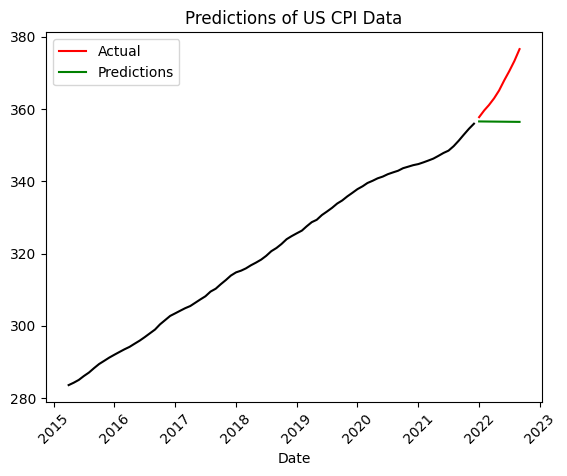

In [17]:
# Get predictions series
y_pred_out = y_pred_df["Predictions"]

# Plot
plt.plot(train, color = 'black')
plt.plot(test, color = 'red', label = 'Actual')
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.ylabel('')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Predictions of US CPI Data")
plt.legend();

**Question 2.1:** Why does the predictions look almost constant?

1. Because ARMA is a bad model for this time series
2. Because we did not give ARMA a reasonable set of orders (i.e. p and q)
3. Because the data is too volatile to predict

Assign the number corresponding to your answer to `q2_1` below.

In [18]:
q2_1 = 2

In [19]:
grader.check("q2_1")

q2_1 results: All test cases passed!

We can also compute the loss of this model. 

In [20]:
arma_rmse = np.sqrt(mean_squared_error(test["CPI"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  11.370077728421151


### Autoregressive Integrated Moving Average (ARIMA)

The notation ARIMA(p, d, q) refers to the model with p autoregressive terms with d degree of differencing and q moving-average terms. 

$$X_t' = c + \underbrace{\phi_1 X_{t-1}' + \phi_2 X_{t-2}' + \cdots + \phi_p X_{t-p}'}_{AR(p)} + \underbrace{\theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \cdots + \theta_q \varepsilon_{t-q}}_{MA(q)} + \varepsilon_t $$ 

where $y_t'$ is the differenced series (it may have been differenced more than once).

**Difference between ARMA and ARIMA**: The only difference is the “integrated” part. Integrated refers to the number of times needed to difference a series in order to achieve stationarity, which is required for ARMA models to be valid. So ARMA is a special case of ARIMA with $d = 0$. ARIMA models are widely used for real life time series analysis since most times series data are non stationary and need differencing.

Here's a summary table for the relationship between the ARIMA model and the models discussed. 

| Model | ARIMA(p, d, q) |
| ----------- | ----------- |
| White noise | ARIMA(0,0,0) |
| Random walk | ARIMA(0,1,0) with no constant |
| Random walk with drift | ARIMA(0,1,0) with a constant |
| Autoregression (AR(p)) | ARIMA(p,0,0) |
| Moving average (MA(q)) | ARIMA(0,0,q) |
| Autoregressive Moving Average (ARMA(p,q)) | ARIMA(p,0,q) |

Now let's try fit our data using $\text{ARIMA}(1, 1, 1)$. 

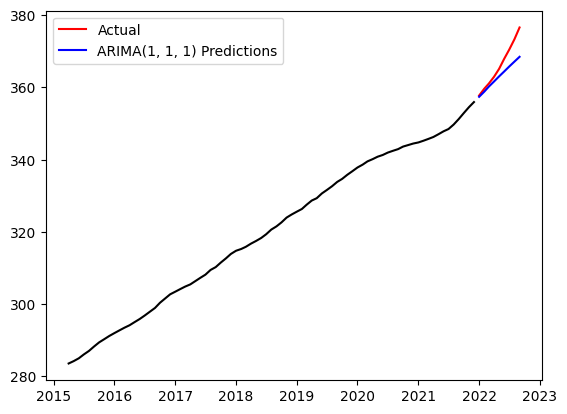

In [21]:
ARIMAmodel_naive = ARIMA(y_train, order = (1, 1, 1))
ARIMAmodel_naive = ARIMAmodel_naive.fit()

y_pred = ARIMAmodel_naive.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel_naive.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(train, color = "black")
plt.plot(test, color = "red", label = 'Actual')
plt.plot(y_pred_out, color='blue', label = 'ARIMA(1, 1, 1) Predictions')
plt.legend();

In [22]:
arima_naive_rmse = np.sqrt(mean_squared_error(test["CPI"].values, y_pred_df["Predictions"]))
print("RMSE: ",arima_naive_rmse)

RMSE:  4.02567379511991


After adding $d=1$ differencing, the predictions look much better than before!

However, the ARIMA model for time series analysis and forecasting can be tricky to configure.

There are 3 parameters (p, d and q) that require estimation by iterative trial and error from reviewing diagnostic plots and using 40-year-old heuristic rules. Usually we will find optimal parameters with ACF, PACF plots, and BIC/AIC information criteria or simply do a grid search, but we will not go into depth about these topics here. If you are interested, you can learn more about this in Stat 153. 

<!-- BEGIN QUESTION -->

**Question 2.2:** Let's find some better parameters using trial and error. Try some combinations of p, d and q and see what is the result of the predictions. We will manually grade this question, and in order to recieve full credit, you must achieve an RMSE of less than 3.5 and a plot of your predictions vs the actual values must be shown.

Hint: Think about what does p, d, q mean in the ARIMA model. 

When not worrying about overfitting, I can set up a simple grid search in a range of 0 through 6 (i.e. dependent on up to the last six months and stationary in up to the sixth difference) for each parameter to minimize the RMSE and found the optimal parameters to be `(p, d, q) = (0, 6, 6)` resulting in $RMSE = 0.375056$.

In [23]:
# define function for the model to iterate over
def ARIMA_test(train, test, order=(1, 1, 1),log=False):
    if log:
        train = np.log(train)
    ARIMAmodel = ARIMA(train, order = order)
    ARIMAmodel = ARIMAmodel.fit()
    y_pred_arima = ARIMAmodel.get_forecast(len(test.index)) # generate predictions
    y_pred_arima_df = y_pred_arima.conf_int(alpha = 0.05)
    y_pred_arima_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
    y_pred_arima_df.index = test.index
    if log:
        y_pred_arima_df["Predictions"] = np.exp(y_pred_arima_df["Predictions"])
    y_pred_arima_out = y_pred_arima_df["Predictions"] 

    arima_rmse = np.sqrt(mean_squared_error(test["CPI"].values, y_pred_arima_out))
    return arima_rmse, y_pred_arima_out

In [24]:
# create a grid for brute forcing
grid = [(p, d, q) for p in range(7) for d in range(7) for q in range(7)]

# brute force to find the best ARIMA model
results = []
for p, d, q in grid:
    try:
        rmse = ARIMA_test(train, test, order=(p, d, q))[0]
        results.append((p, d, q, rmse))
    except:
        continue

results_df = pd.DataFrame(results, columns = ['p', 'd', 'q', 'RMSE']).sort_values('RMSE')
results_df.head(5)

,p,d,q,RMSE
48,0,6,6,0.375056
97,1,6,6,0.431818
145,2,6,5,0.435312
290,5,6,5,0.462546
339,6,6,5,0.529545


If the solution should be slightly more pragmatic and worry about overfitting, I can start looking at the meaning of the parameter for the integrated part. The `d` parameter is the number of times the data is differenced. As we are working with CPI and we assume the FED in the long run are successful with their target inflation of around $\sim 2\%$ YoY (though they usually look at PCE), the log-first difference would be stationary with a constant level around $1.02^{1/ 12}-1 \approx 0.00165$ MoM. To remove this constant part, I set `d=2`. 

For the moving average part (shock persistency) and the autoregressive part (momentum), I will again seek to minimize the RMSE with up to six months of persistency. I found the optimal parameters to be `(p, d, q) = (6, 2, 6)`, resulting in $RMSE = 2.104195$.

In [25]:
# plot acf and pacf

In [26]:
# create a grid for brute forcing
grid = [(p, 2, q) for p in range(7) for q in range(7)]

# brute force to find the best ARIMA model
results = []
for p, d, q in grid:
    try:
        rmse = ARIMA_test(train, test, order=(p, d, q), log=True)[0]
        results.append((p, d, q, rmse))
    except:
        continue

results_df_ln = pd.DataFrame(results, columns = ['p', 'd', 'q', 'RMSE']).sort_values('RMSE')
results_df_ln.head(5)

,p,d,q,RMSE
48,6,2,6,2.104195
5,0,2,5,3.252532
12,1,2,5,3.358089
19,2,2,5,3.359002
35,5,2,0,3.360853


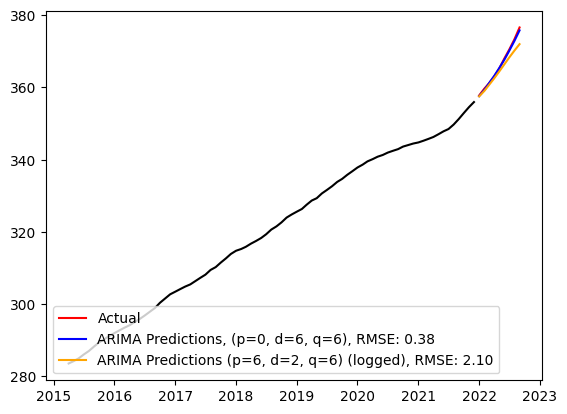

In [27]:
# rerun model with best parameters and plot
opt = results_df.iloc[0, :3]
opt_ln = results_df_ln.iloc[0, :3]
ARIMA_opt = ARIMA_test(train, test, order=opt)
ARIMA_ln = ARIMA_test(train, test, order = opt_ln, log=True)

plt.plot(train, color = "black") # plot
plt.plot(test, color = "red", label = 'Actual')
plt.plot(ARIMA_opt[1], color='blue', label = f'ARIMA Predictions, (p={opt[0]:.0f}, d={opt[1]:.0f}, q={opt[2]:.0f}), RMSE: {ARIMA_opt[0]:.2f}')
plt.plot(ARIMA_ln[1], color='orange', label = f'ARIMA Predictions (p={opt_ln[0]:.0f}, d={opt_ln[1]:.0f}, q={opt_ln[2]:.0f}) (logged), RMSE: {ARIMA_ln[0]:.2f}')
plt.legend(loc='lower left');

The first model found solely by minimizing the RMSE closely resembles the actual data – however, it is likely overfitting. While not as close to the actual data, the second model is likely more robust and generalizes better. One could also consider an ARIMA(1,2,1) on the logged series would be best to avoid overfitting – this would yield $RMSE=3.45$.

<!-- END QUESTION -->

However, in the real world when we don't know the future values, such tuning can lead to overfitting. So we need to be aware of the [bias-variance tradeoff](https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229) when tuning our time series model. 

## The below subparts (excluding the survey at the very end) are OPTIONAL

<div class="alert alert-info">

**Note:** You have now finished all the coding that is required for this lab - congratulations! The below parts (minus the survey at the very end) are purely optional, if you wish to extend your knowledge further. If you do not wish to finish these parts, feel free to scroll down, fill out the survey and then submit the lab!

</div>

### Seasonal Autoregressive Integrated Moving Average (SARIMA)
So far, we have restricted our attention to non-seasonal data and non-seasonal ARIMA models. However, ARIMA models are also capable of modelling a wide range of seasonal data.

A seasonal ARIMA model is formed by including additional seasonal terms in the ARIMA models we have seen so far. It is written as follows:

$$\text{ARIMA} (p, d, q) (P, D, Q)_m$$

where $m$ is the number of observations per year. For example, $m=12$ is for monthly data and $m=4$ is for quarterly data. 

**Question 2.3:** What should $m$ be for our dataset?

In [28]:
m = 12

In [29]:
grader.check("q2_3")

q2_3 results: All test cases passed!

Let's try fit our data using $\text{ARIMA} (5, 4, 2) (2, 2, 2)_{m}$. 

In [30]:
SARIMAXmodel = SARIMAX(y_train, order = (5, 4, 2), seasonal_order=(2,2,2,m))
SARIMAXmodel = SARIMAXmodel.fit(disp=0)

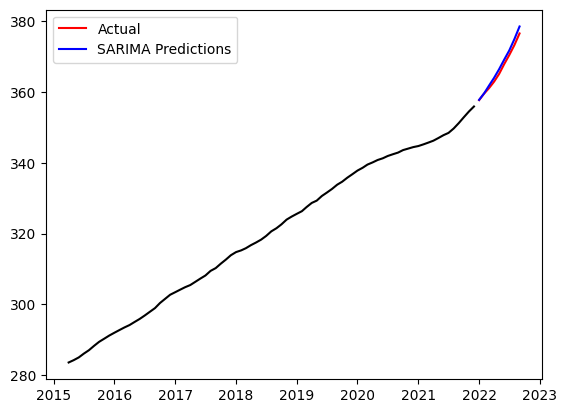

In [31]:
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(train, color = "black")
plt.plot(test, color = "red", label = 'Actual')
plt.plot(y_pred_out, color='Blue', label = 'SARIMA Predictions')
plt.legend()

In [32]:
sarima_rmse = np.sqrt(mean_squared_error(test["CPI"].values, y_pred_df["Predictions"]))
print("RMSE: ",sarima_rmse)

RMSE:  1.2224877370450529


**Question 2.4:** It seems that the SARIMA model doesn't help too much with our predictions. Why?

1. Because SARIMA is not an improvement to ARIMA for this time series
2. Because we did not give SARIMA a reasonable set of orders
3. Because the data is too volatile to predict

Assign the number corresponding to your answer to `q2_4` below.

In [33]:
q2_4 = 1

In [34]:
grader.check("q2_4")

q2_4 results: All test cases passed!
q2_4 - 1 message: Correct. Our CPI series is already a seasonally adjusted series!

---
## Part 3: Time Series with Multiple Series

We want to combine both time series so that we can analyze them together. However, we notice that the `DATE` column has different values. ZORI is measured on the 31st of each month, while CPI is measured on the 1st day of each month. For our purposes, we can combine the two by using the `DATE` index from the US CPI and using the 1st day of the month.

In [35]:
combined = pd.concat([zillow.reset_index(drop=True), usCPI.reset_index(drop=True)], axis=1)
combined.index = usCPI.index
combined

,ZORI,CPI
DATE,,
2015-04-01,1370.301806,283.598
2015-05-01,1381.971304,284.245
2015-06-01,1392.389090,285.031
2015-07-01,1403.203509,286.090
2015-08-01,1408.901384,287.068
...,...,...
2022-05-01,1997.731260,365.116
2022-06-01,2019.752839,367.927
2022-07-01,2044.662959,370.448


### Visual Comparison

We can try plotting this graph to see if we can find anything interesting.

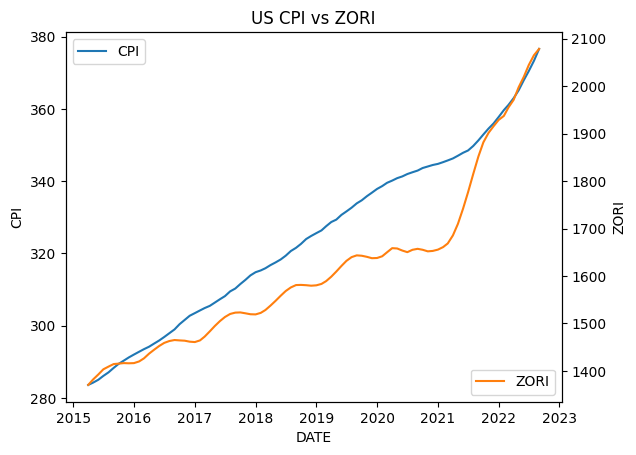

In [36]:
sns.lineplot(data=combined, x="DATE", y="CPI", color='tab:blue', label='CPI')
ax2 = plt.twinx()
sns.lineplot(data=combined, x="DATE", y="ZORI", color='tab:orange', ax=ax2, label='ZORI')
plt.legend(loc='upper left')
ax2.legend(loc='lower right')
plt.title("US CPI vs ZORI");

#### Logging Our Data

We can try logging our data to make them easier to compare.

**Question 3.1:** Take the natural log for `CPI` and `ZORI` and store the results in new columns `log CPI` and `log ZORI`. Then make a plot similar to the one above. 

Hint: You may want to convert both column `ZORI` and `CPI` to `float64` before taking the natural log. 

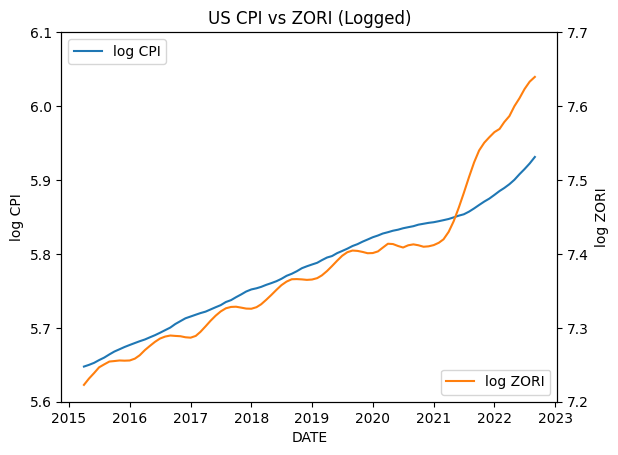

In [37]:

combined["log CPI"] = np.log(combined["CPI"])
combined["log ZORI"] = np.log(combined["ZORI"])

sns.lineplot(data=combined, x='DATE', y='log CPI', color='tab:blue', label='log CPI')
plt.ylim([5.6, 6.1])
plt.legend(loc='upper left')

ax2 = plt.twinx()
sns.lineplot(data=combined, x='DATE', y='log ZORI', color='tab:orange', ax=ax2, label='log ZORI')
ax2.set_ylim([7.2, 7.7])
ax2.legend(loc='lower right')
plt.title("US CPI vs ZORI (Logged)");

In [38]:
grader.check("q3_1")

q3_1 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 3.2:** Which time series is more volatile? What can be one possible explanation?

The Zillow Observed Rent Index is the most volatile of the time series. This is explained by the fact that the ZORI only considers rent and is thus more sensitive than a broader index like the CPI. This is especially true for interest rates, which affect the housing market more than the general economy.

<!-- END QUESTION -->



In [39]:
# correlation
rho, pvalue = stats.pearsonr(combined["log CPI"], combined["log ZORI"])
print("Correlation: ", rho)
print("P-value: ", pvalue)

Correlation:  0.9546514472682945
P-value:  4.405480838191599e-48


### Vector Autoregressive (VAR) Models

One limitation of the models that we have considered so far is that they impose a unidirectional relationship — the forecast variable is influenced by the predictor variables, but not vice versa. However, there are many cases where the reverse should also be allowed for — where all variables affect each other. For example, in our case CPI and ZORI can be predictor for each other since they are highly correlated series.  

A VAR model is a generalization of the univariate autoregressive model for forecasting a vector of time series. We will not go into the math behind VAR model in this class. 

In [40]:
# Import Statsmodels packages
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [41]:
var_df = combined[["CPI", "ZORI"]]
var_df

,CPI,ZORI
DATE,,
2015-04-01,283.598,1370.301806
2015-05-01,284.245,1381.971304
2015-06-01,285.031,1392.389090
2015-07-01,286.090,1403.203509
2015-08-01,287.068,1408.901384
...,...,...
2022-05-01,365.116,1997.731260
2022-06-01,367.927,2019.752839
2022-07-01,370.448,2044.662959


#### Splitting into Training and Testing Groups

In [42]:
nobs = 4
df_train, df_test = var_df[0:-nobs], var_df[-nobs:]

# Check size
print(df_train.shape) 
print(df_test.shape)

(86, 2)
(4, 2)


In [43]:
df_train.dtypes

CPI     float64
ZORI    float64
dtype: object

---
### Step 1: Checking Correlations

#### Granger Causality
We first use Granger's Causality Tests to see the p-value of the correlations between different variables.

In [44]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [45]:
grangers_causation_matrix(var_df, variables = var_df.columns) 

,CPI_x,ZORI_x
CPI_y,1.0000,0.0
ZORI_y,0.0119,1.0


<!-- BEGIN QUESTION -->

**Question 3.3:** How can we interpret the findings above?

Hint: Read the docstring for the function `grangers_causation_matrix`. 

Granger causality does not necessarily imply causality; rather, it is a statistical concept that explains whether one time series is useful in forecasting another. From the matrix above, we can see that both ZORI_x CPI_y and CPI_x and ZORI_y have values below the significance level, and thus, granger causes each other. The effect, however, is stronger from ZORI to CPI than the other way around.

<!-- END QUESTION -->

#### Cointegration Test
We can also use a cointegration test to see if the two time series are correlated before making any predictions.

In [46]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [47]:
cointegration_test(var_df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
CPI    ::  20.2      > 12.3212   =>   True
ZORI   ::  5.2       > 4.1296    =>   True


### Step 2: Transforming the Time Series to be Stationary
In order to perform our VAR test, we want our time series to be stationary. A stationary time series is one whose characteristics like mean and variance does not change over time. This is similar to what we have done with ARIMA model. 

Augmented Dickey Fuller test (ADFuller or ADF Test) is a common statistical test used to test whether a given Time series is stationary or not. It is one of the most commonly used statistical test when it comes to analyzing the stationary of a series.

In [48]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

We will keep differencing the data series until we pass the ADFuller test for stationarity. 

#### First Iteration (with no differencing)

In [49]:
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.0281
 No. Lags Chosen       = 2
 Critical value 1%     = -3.512
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.9946. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ZORI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.355
 No. Lags Chosen       = 7
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.9969. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




#### Second Iteration

In [50]:
df_differenced = df_train.diff().dropna()

In [51]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.3492
 No. Lags Chosen       = 1
 Critical value 1%     = -3.512
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.6064. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ZORI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.5727
 No. Lags Chosen       = 6
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.877. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




#### Third Iteration

In [52]:
df_differenced = df_differenced.diff().dropna()

In [53]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.856
 No. Lags Chosen       = 0
 Critical value 1%     = -3.512
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ZORI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.0602
 No. Lags Chosen       = 5
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




Now it seems that both series are stationary. 

### Step 3: Fitting the Model

In [54]:
model = VAR(df_differenced)
for i in [1,3,5,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -0.21026376340086728
BIC :  -0.03540781584930597
FPE :  0.8104215346830951
HQIC:  -0.14001643485826226 

Lag Order = 3
AIC :  -0.36170542164107533
BIC :  0.05214998780848212
FPE :  0.6970898329062676
HQIC:  -0.19566120825064925 

Lag Order = 5
AIC :  -0.31964473612037547
BIC :  0.34020150127550397
FPE :  0.7290573861095475
HQIC:  -0.0552901453698309 

Lag Order = 9
AIC :  -0.3820421056598047
BIC :  0.7921518718652589
FPE :  0.6980327511351829
HQIC:  0.08680065599159414 



In [55]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 02, Apr, 2024
Time:                     17:19:33
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  0.0521500
Nobs:                     81.0000    HQIC:                 -0.195661
Log likelihood:          -201.219    FPE:                   0.697090
AIC:                    -0.361705    Det(Omega_mle):        0.590600
--------------------------------------------------------------------
Results for equation CPI
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.018346         0.026775            0.685           0.493
L1.CPI         -0.447558         0.118263           -3.784           0.000
L1.ZORI        -0.003679         0.008218           -0.448           0.654
L2.CPI     

In [56]:
from statsmodels.stats.stattools import durbin_watson

def adjust(val, length= 6): return str(val).ljust(length)
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_differenced.columns, out):
    print(adjust(col), ':', round(val, 2))

CPI    : 2.03
ZORI   : 1.9


### Step 4: Making Predictions

In [57]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

3


array([[-0.434     ,  9.60846668],
       [ 0.412     , -1.98278112],
       [ 0.297     , 10.48934293]])

In [58]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=var_df.index[-nobs:], columns=var_df.columns + '_2d')
df_forecast

,CPI_2d,ZORI_2d
DATE,,
2022-06-01,-0.196554,-1.083348
2022-07-01,0.221501,2.437672
2022-08-01,0.030502,-4.137291
2022-09-01,-0.004706,0.044825


These are the differenced results. We want to de-difference it to get it back in terms of the original.

In [59]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [60]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results

,CPI_2d,ZORI_2d,CPI_1d,CPI_forecast,ZORI_1d,ZORI_forecast
DATE,,,,,,
2022-06-01,-0.196554,-1.083348,1.968446,367.084446,25.390923,2023.122183
2022-07-01,0.221501,2.437672,2.189947,369.274393,27.828596,2050.950778
2022-08-01,0.030502,-4.137291,2.220449,371.494842,23.691304,2074.642083
2022-09-01,-0.004706,0.044825,2.215743,373.710585,23.736129,2098.378212


We plot our predictions against actual values.

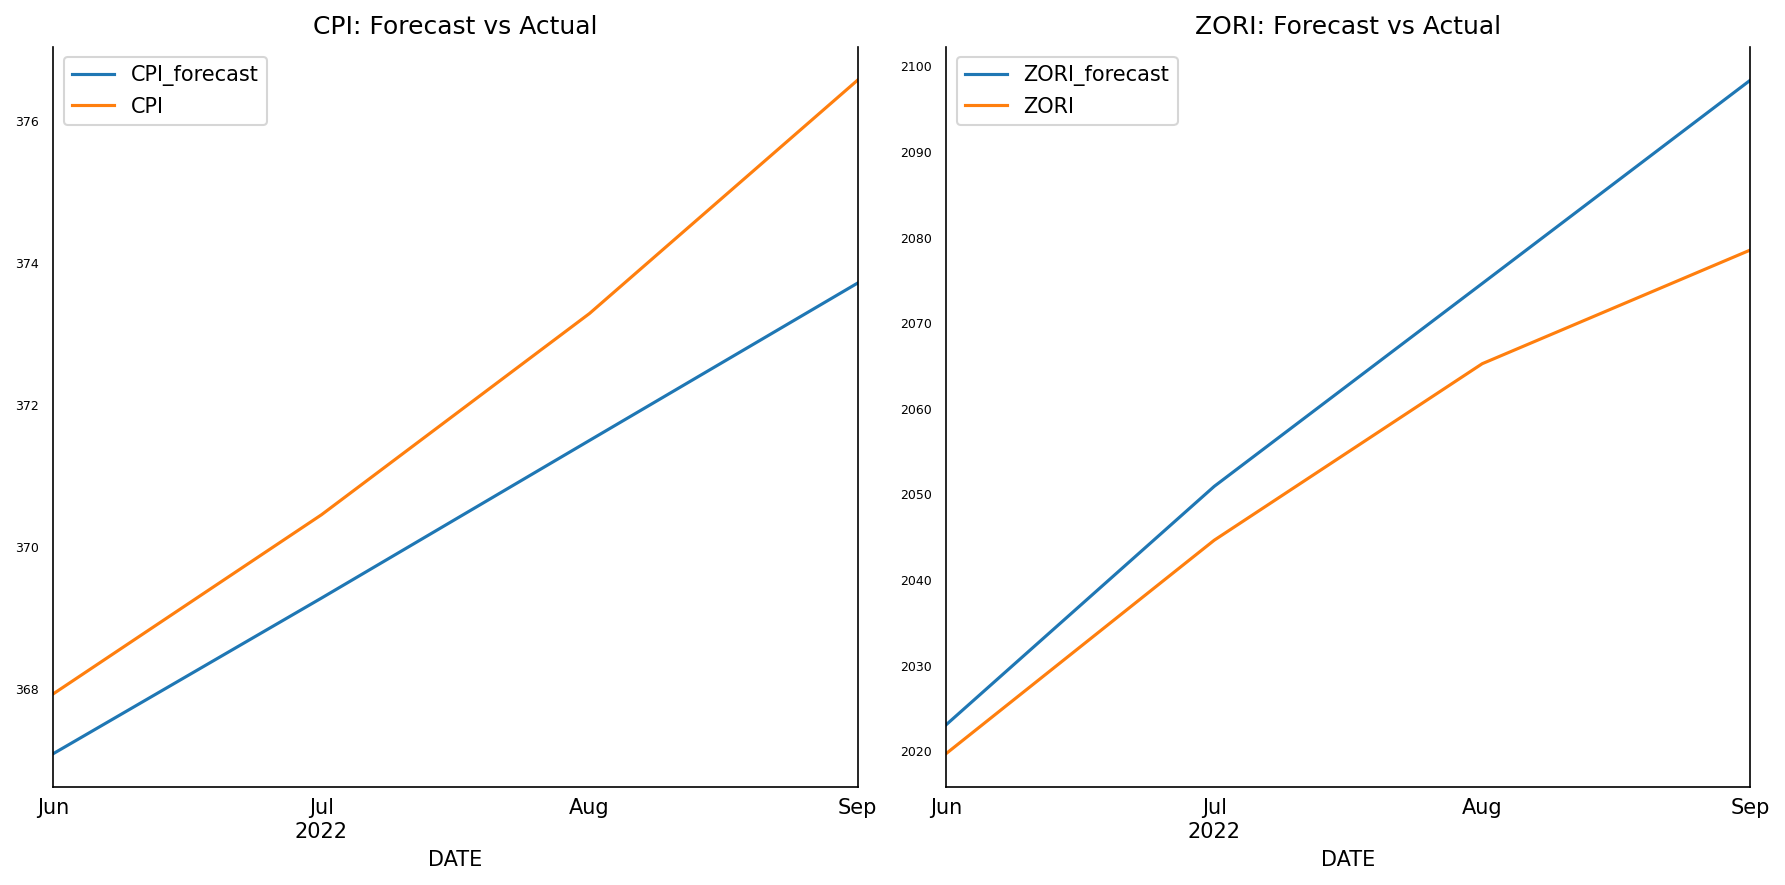

In [61]:
fig, axes = plt.subplots(nrows=int(len(var_df.columns)/2), ncols=2, dpi=150, figsize=(12,6))
for i, (col,ax) in enumerate(zip(var_df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actual")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### Step 5: Finding RMSE

In [62]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: ZORI')
accuracy_prod = forecast_accuracy(df_results['ZORI_forecast'].values, df_test['ZORI'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: ZORI
mape   :  0.0047
me     :  9.7139
mae    :  9.7139
mpe    :  0.0047
rmse   :  11.5318
corr   :  0.995
minmax :  0.0047


**Congrats on making it to the end of the lab!**

---
## Feedback

**Question 4:** Please fill out this short [feedback form](https://forms.gle/xG5mo6UqvmpF1af78) to let us know your thoughts about this lab! We really appreciate your opinions and feedback! At the end of the Google form, you should see a codeword. Assign the codeword to the variable `codeword` below. 

In [63]:
codeword = 'train'

In [64]:
grader.check("q4")

q4 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [65]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q1_2 results: All test cases passed!

    q1_3 results: All test cases passed!

    q2_1 results: All test cases passed!

    q2_3 results: All test cases passed!

    q2_4 results: All test cases passed!
    q2_4 - 1 message: Correct. Our CPI series is already a seasonally adjusted series!

    q3_1 results: All test cases passed!

    q4 results: All test cases passed!
